In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from gym_guppy.envs import VariableStepGuppyEnv
from gym_guppy.guppies import GlobalTargetRobot

from gym_guppy.tools.math import sigmoid
from gym_guppy.tools.controller import ForwardController, TurnController, TwoWheelsController

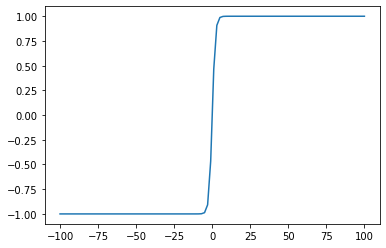

In [2]:
slope_dist = 1.
error = np.linspace(-100., 100., 100)

s = sigmoid(error, slope_dist)
plt.plot(error, s)

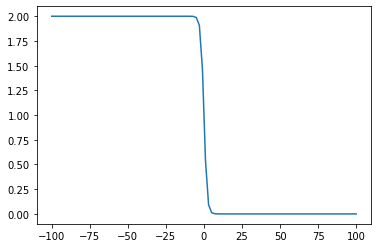

In [3]:
s = sigmoid(error, slope_dist)
plt.plot(error, 1.-s)

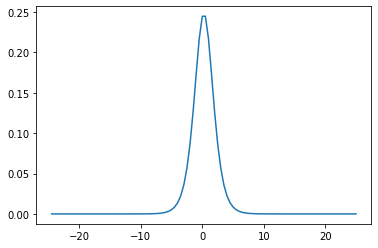

In [4]:
error = np.linspace(-25., 25., 101)
s1 = sigmoid(error[1:], slope_dist)
s2 = sigmoid(error[:-1], slope_dist)
plt.plot(error[1:], s1-s2)

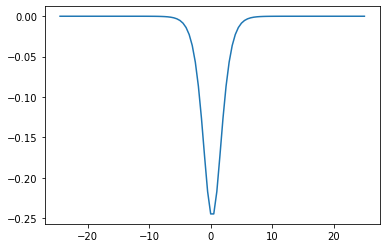

In [5]:
plt.plot(error[1:], (1.-s1)-(1.-s2))

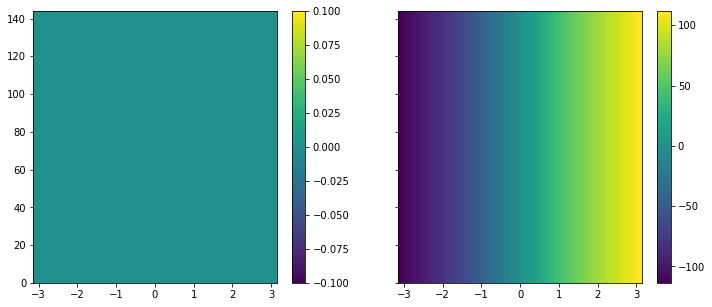

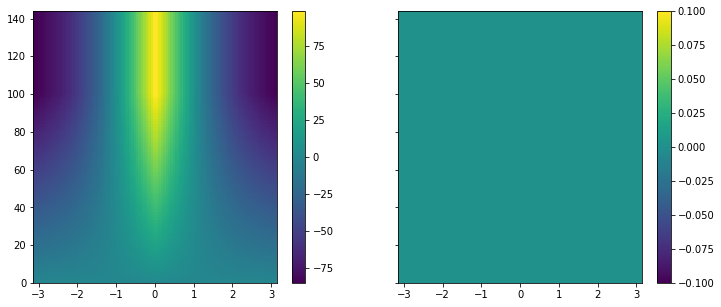

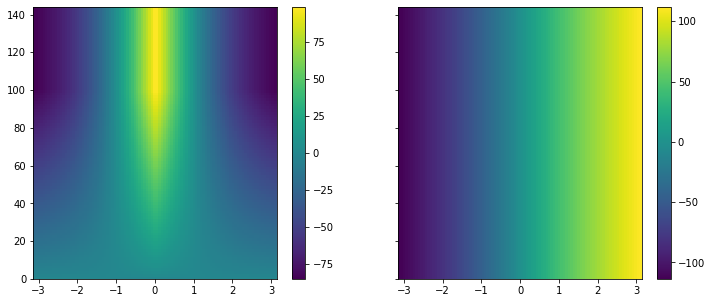

In [6]:
ori_error = np.linspace(-np.pi, np.pi, 100)
pos_error = np.linspace(.0, 144., 100)
ori_e, pos_e = np.meshgrid(ori_error, pos_error)

ori_controller = TurnController()
ori_motor_speeds = ori_controller(ori_e, pos_e)

x_vel, r_vel = ori_motor_speeds.get_local_velocities()

f, (ax0, ax1) = plt.subplots(ncols=2, sharey=True, figsize=(12, 5))
pcm0 = ax0.pcolormesh(ori_e, pos_e, x_vel)
plt.colorbar(pcm0, ax=ax0)
pcm1 = ax1.pcolormesh(ori_e, pos_e, r_vel)
plt.colorbar(pcm1, ax=ax1)

fwd_controller = ForwardController()
fwd_motor_speeds = fwd_controller(ori_e, pos_e)

x_vel, r_vel = fwd_motor_speeds.get_local_velocities()

f, (ax0, ax1) = plt.subplots(ncols=2, sharey=True, figsize=(12, 5))
pcm0 = ax0.pcolormesh(ori_e, pos_e, x_vel)
plt.colorbar(pcm0, ax=ax0)
pcm1 = ax1.pcolormesh(ori_e, pos_e, r_vel)
plt.colorbar(pcm1, ax=ax1)

x_vel, r_vel = (fwd_motor_speeds + ori_motor_speeds).get_local_velocities()

f, (ax0, ax1) = plt.subplots(ncols=2, sharey=True, figsize=(12, 5))
pcm0 = ax0.pcolormesh(ori_e, pos_e, x_vel)
plt.colorbar(pcm0, ax=ax0)
pcm1 = ax1.pcolormesh(ori_e, pos_e, r_vel)
plt.colorbar(pcm1, ax=ax1)

In [30]:
controller_params = {
    'ori_ctrl_params': {
        'p': 1.2,
        'i': 0.,
        'd': 0.,
        'speed': .2,
        'slope': .75  # .65
    },
    'fwd_ctrl_params': {
        'p': 1.,
        'i': 0.,
        'd': 1.,
        'speed': .2,
        'slope': .5,
        'ori_gate_slope': 3.
    }
}

class TestEnv(VariableStepGuppyEnv):
    world_size = world_width, world_height = 1., 1.
    def _reset(self):
        self._add_robot(GlobalTargetRobot(world=self.world,
                                      world_bounds=self.world_bounds,
                                      position=np.array([-0.000346, 0.006494]),
                                      orientation=2.391885,
                                      ctrl_params=controller_params))

env = TestEnv(max_steps_per_action=500)
# env.render('human')

In [8]:
# del env

next target: [0. 0.]
next target: [-0.3  0.3]
next target: [0.3 0.3]
next target: [ 0.3 -0.3]
next target: [-0.3 -0.3]
next target: [-0.3  0.3]
next target: [0. 0.]


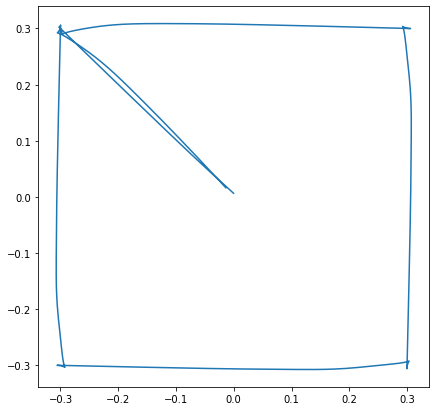

In [31]:
env.reset()
action_list = np.array([[.0, .0],
                        [-.3, .3],
                        [.3, .3],
                        [.3, -.3],
                        [-.3, -.3],
                        [-.3, .3],
                        [.0, .0]])

# action_list = np.array([[.0, .0],
#                         [-.1, .0]])

steps = []

for a in action_list:
    print(f'next target: {a}')
    # local_action = env.robot.get_local_point(a)
    observation, reward, done, info = env.step(a)
    if not len(info['steps']) == 0:
        steps.append(info['steps'])
    
steps_array = np.concatenate(steps)
f, ax = plt.subplots(figsize=(7,7))
ax.plot(steps_array[:, 1], steps_array[:, 2])

In [32]:
steps_df = pd.DataFrame(steps_array, columns=['time', 'pos_x', 'pos_y', 'ori_rad', 'vel_x', 'vel_y', 'vel_r'])

steps_df['dt'] = steps_df.time.diff()
steps_df['rel_time'] = steps_df.time - steps_df.time.iloc[0]
    

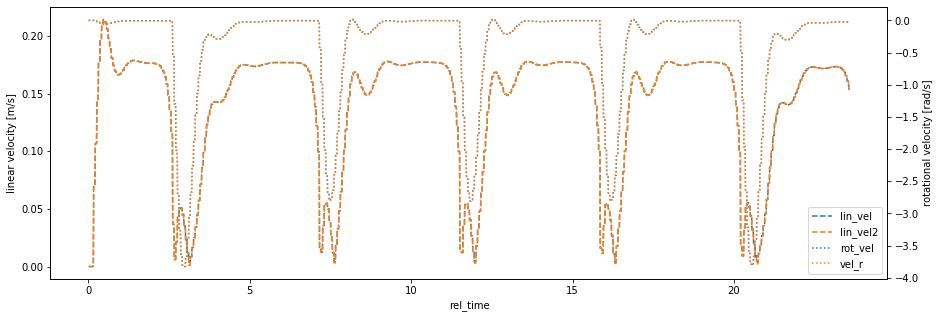

In [33]:
steps_df['lin_vel'] = np.sqrt(np.sum(steps_df[['pos_x', 'pos_y']].diff(axis=0)**2, axis=1)) / steps_df['dt']
steps_df['lin_vel2'] = np.sqrt(np.sum(steps_df[['vel_x', 'vel_y']]**2, axis=1))
steps_df['rot_vel'] = steps_df['ori_rad'].diff() * 100.
steps_df.loc[steps_df['ori_rad'] >= +np.pi, 'ori_rad'] -= 2*np.pi
steps_df.loc[steps_df['ori_rad'] <= -np.pi, 'ori_rad'] += 2*np.pi

f, ax1 = plt.subplots(figsize=(15,5))

l1 = steps_df.plot(ax=ax1, x='rel_time', y=['lin_vel', 'lin_vel2'], legend=False, ls='--')
ax1.set_ylabel('linear velocity [m/s]')

ax2 = ax1.twinx()

l2 = steps_df.plot(ax=ax2, x='rel_time', y=['rot_vel', 'vel_r'], legend=False, ls=':')
ax2.set_ylabel('rotational velocity [rad/s]')

lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='lower right')

In [34]:
# /Users/gregor/Cloud/box.fu/data/robofish/2020-01-30-14-57_trajectory_with_pwm.csv
# /Users/gregor/Cloud/box.fu/data/robofish/2020-02-06-18-42_trajectory_with_pwm.csv
robot_tj = pd.read_csv('/Users/gregor/Cloud/box.fu/data/robofish/2020-02-20-15-55_action_test_behavior_trajectory_with_pwm.csv', index_col=0)


robot_tj['pos_x_m'] = (robot_tj['pos_x'] / 100.) - .5
robot_tj['pos_y_m'] = (-robot_tj['pos_y'] / 100.) + .5
robot_tj['ori_rad'] *= -1
print(robot_tj.loc[:10, ['pos_x_m', 'pos_y_m', 'ori_rad']])
robot_tj.columns

     pos_x_m   pos_y_m   ori_rad
0  -0.000346  0.006494  2.391885
1   0.000268  0.006497  2.416306
2   0.000268  0.006497  2.416306
3   0.000274  0.005877  2.393028
4  -0.000955  0.005870  2.438443
5  -0.004044  0.007713  2.484641
6  -0.005272  0.007706  2.538053
7  -0.008361  0.009548  2.530300
8  -0.010234  0.012637  2.538015
9  -0.014545  0.013853  2.510759
10 -0.020753  0.020636  2.479421


Index(['time_millis', 'pwm_left', 'pwm_right', 'rpm_left', 'rpm_right',
       'pwm_cap', 'cm_per_rotation', 'speeds_left', 'speeds_right', 'pos_x',
       'pos_y', 'ori_x', 'ori_y', 'ori_rad', 'target_x', 'target_y',
       'time_python_entry', 'time_python_exit', 'pos_x_m', 'pos_y_m'],
      dtype='object')

24.95313476359092

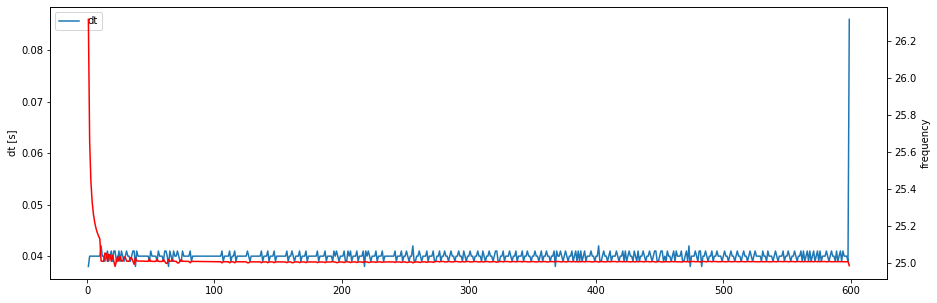

In [35]:
from gym_guppy.tools.controller import MotorSpeeds

for i in robot_tj.index:
    ms = MotorSpeeds(robot_tj.loc[i].speeds_left/100., robot_tj.loc[i].speeds_right/100.)
    pwm_commands = ms.vel_to_pwm()
    robot_tj.loc[i, 'py_pwm_left'] = pwm_commands.left
    robot_tj.loc[i, 'py_pwm_right'] = pwm_commands.right
    x_vel, r_vel = pwm_commands.pwm_to_vel().get_local_velocities()
    robot_tj.loc[i, 'py_x_vel'] = x_vel
    robot_tj.loc[i, 'py_r_vel'] = r_vel
    x_vel, r_vel = ms.get_local_velocities()
    robot_tj.loc[i, 'py_x_vel_dir'] = x_vel
    robot_tj.loc[i, 'py_r_vel_dir'] = r_vel

robot_tj['dt'] = robot_tj.time_millis.diff() / 1000.
robot_tj['dt2'] = robot_tj.time_millis.diff(periods=2) / 1000.
robot_tj['dt3'] = robot_tj.time_millis.diff(periods=3) / 1000.
robot_tj['dt4'] = robot_tj.time_millis.diff(periods=4) / 1000.
robot_tj['dt5'] = robot_tj.time_millis.diff(periods=5) / 1000.
robot_tj['rel_time'] = (robot_tj.time_millis - robot_tj.time_millis.iloc[0]) / 1000.
robot_tj['pos_x_diff'] = robot_tj['pos_x'].diff()
robot_tj['pos_y_diff'] = robot_tj['pos_y'].diff()
robot_tj['x_vel'] = np.sqrt((robot_tj[['pos_x', 'pos_y']].diff(axis=0)**2).sum(axis=1)) / (100. * robot_tj['dt']) 
robot_tj['x_vel2'] = np.sqrt((robot_tj[['pos_x', 'pos_y']].diff(axis=0, periods=2)**2).sum(axis=1)) / (100. * robot_tj['dt2'])
robot_tj['x_vel3'] = np.sqrt((robot_tj[['pos_x', 'pos_y']].diff(axis=0, periods=3)**2).sum(axis=1)) / (100. * robot_tj['dt3'])
robot_tj['x_vel4'] = np.sqrt((robot_tj[['pos_x', 'pos_y']].diff(axis=0, periods=4)**2).sum(axis=1)) / (100. * robot_tj['dt4'])
robot_tj['x_vel5'] = np.sqrt((robot_tj[['pos_x', 'pos_y']].diff(axis=0, periods=5)**2).sum(axis=1)) / (100. * robot_tj['dt5'])

def fix_period(df, col):
    df.loc[df[col] >= +np.pi, col] -= 2*np.pi
    df.loc[df[col] <= -np.pi, col] += 2*np.pi

robot_tj['r_vel'] = robot_tj['ori_rad'].diff()
fix_period(robot_tj, 'r_vel')
robot_tj['r_vel'] /= robot_tj['dt']
robot_tj['r_vel2'] = robot_tj['ori_rad'].diff(periods=2)
fix_period(robot_tj, 'r_vel2')
robot_tj['r_vel2'] /= robot_tj['dt2']
robot_tj['r_vel3'] = robot_tj['ori_rad'].diff(periods=3)
fix_period(robot_tj, 'r_vel3')
robot_tj['r_vel3'] /= robot_tj['dt3']
robot_tj['r_vel4'] = robot_tj['ori_rad'].diff(periods=4)
fix_period(robot_tj, 'r_vel4')
robot_tj['r_vel4'] /= robot_tj['dt4']
robot_tj['r_vel5'] = robot_tj['ori_rad'].diff(periods=5)
fix_period(robot_tj, 'r_vel5')
robot_tj['r_vel5'] /= robot_tj['dt5']

f, ax1 = plt.subplots(figsize=(15,5))
robot_tj.plot(ax=ax1, y='dt')
ax1.set_ylabel('dt [s]')
ax2 = ax1.twinx()

(1. / robot_tj['dt']).expanding().mean().plot(ax=ax2, c='r', label='frequency')
ax2.set_ylabel('frequency')

1. / robot_tj.dt.mean()

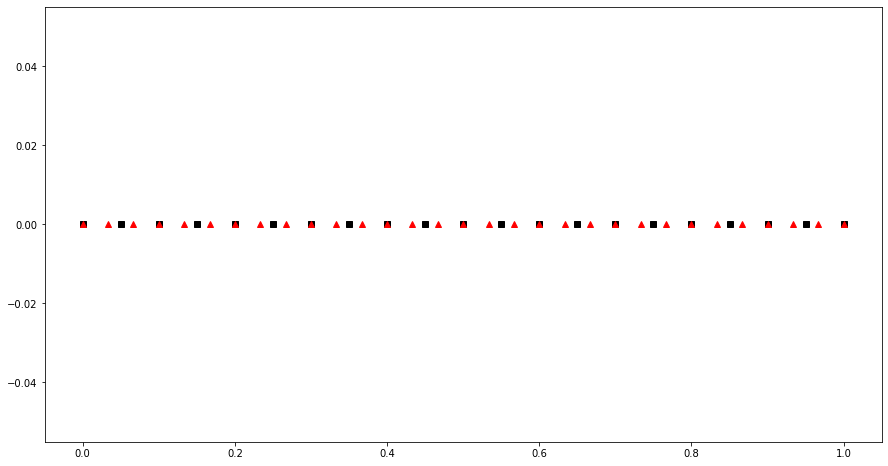

In [36]:
cam = np.linspace(0, 1., 31)
rt = np.linspace(0, 1., 21)

plt.plot(rt, np.zeros_like(rt), 'sk')
plt.plot(cam, np.zeros_like(cam), '^r')

In [37]:
robot_tj.columns

Index(['time_millis', 'pwm_left', 'pwm_right', 'rpm_left', 'rpm_right',
       'pwm_cap', 'cm_per_rotation', 'speeds_left', 'speeds_right', 'pos_x',
       'pos_y', 'ori_x', 'ori_y', 'ori_rad', 'target_x', 'target_y',
       'time_python_entry', 'time_python_exit', 'pos_x_m', 'pos_y_m',
       'py_pwm_left', 'py_pwm_right', 'py_x_vel', 'py_r_vel', 'py_x_vel_dir',
       'py_r_vel_dir', 'dt', 'dt2', 'dt3', 'dt4', 'dt5', 'rel_time',
       'pos_x_diff', 'pos_y_diff', 'x_vel', 'x_vel2', 'x_vel3', 'x_vel4',
       'x_vel5', 'r_vel', 'r_vel2', 'r_vel3', 'r_vel4', 'r_vel5'],
      dtype='object')

Text(0, 0.5, 'y')

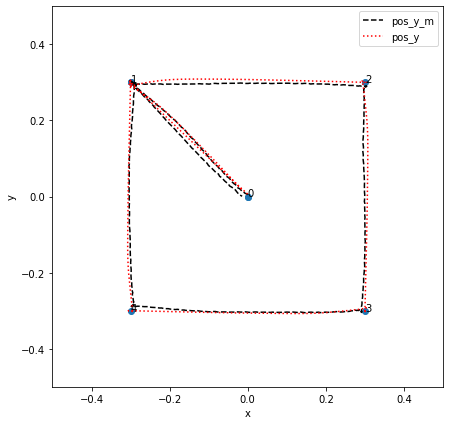

In [38]:
fig, ax = plt.subplots(figsize=(7,7))
ax.scatter(action_list[:,0], action_list[:,1])
for i in range(5):
    ax.annotate(str(i), (action_list[i, 0], action_list[i, 1]))

robot_tj.plot(ax=ax, x='pos_x_m', y='pos_y_m', style='--k')
# ax.plot(robot_tj.pos_x_m, robot_tj.pos_y_m, '--k')

steps_df.plot(ax=ax, x='pos_x', y='pos_y', style=':r')
# ax.plot(steps_array[:, 0], steps_array[:, 1], ':r')

ax.set_xlim(-.5, .5)
ax.set_ylim(-.5, .5)
ax.set_xlabel('x')
ax.set_ylabel('y')

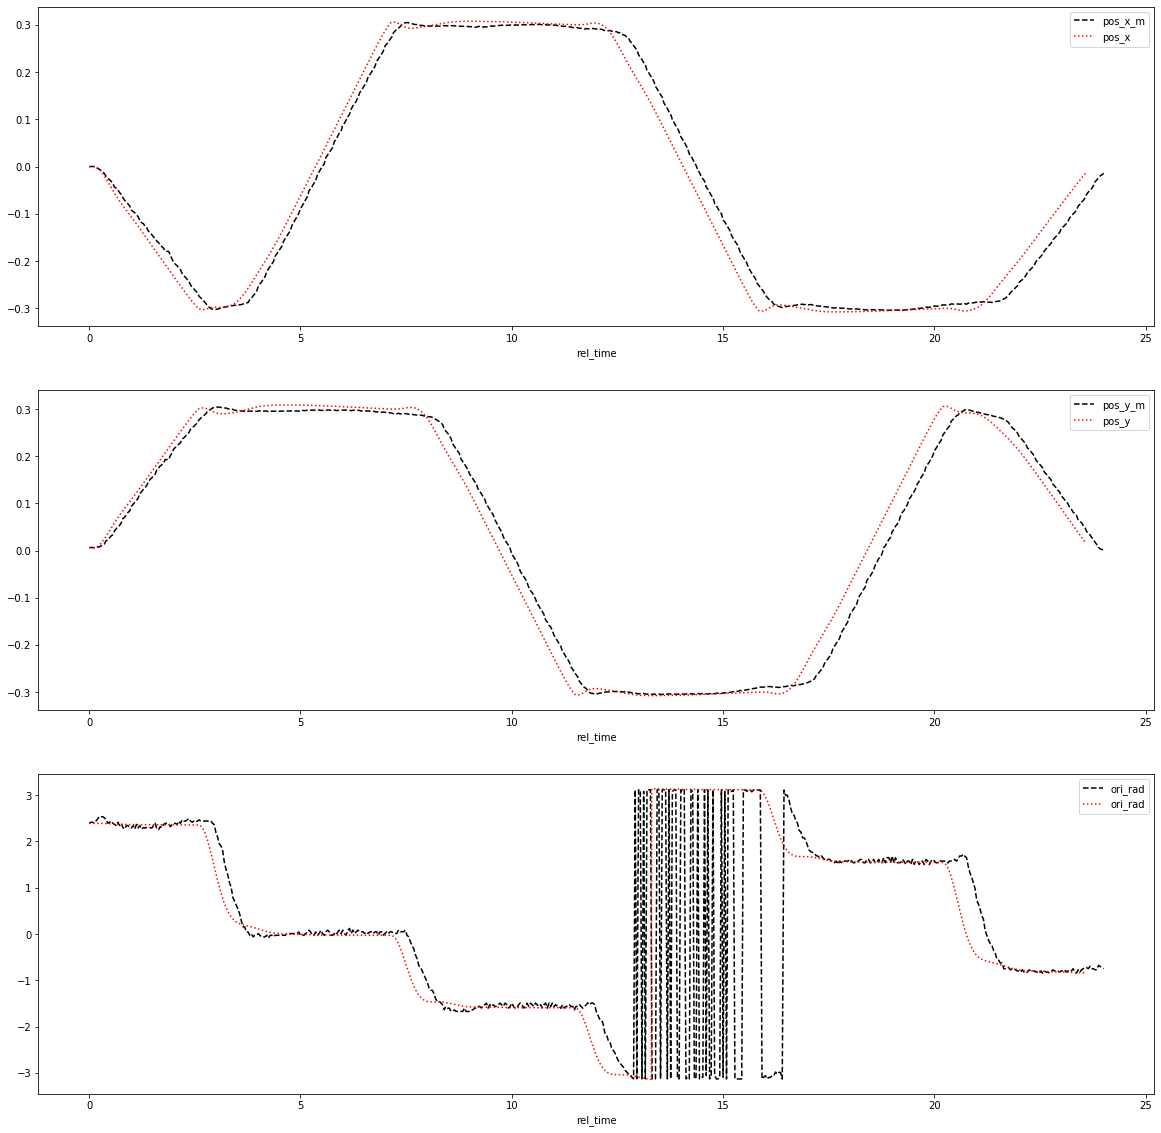

In [39]:
fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(20,20))

robot_tj.plot(ax=ax1, y='pos_x_m', x='rel_time', style='--k')
robot_tj.plot(ax=ax2, y='pos_y_m', x='rel_time', style='--k')
robot_tj.plot(ax=ax3, y='ori_rad', x='rel_time', style='--k')

steps_df.plot(ax=ax1, y='pos_x', x='rel_time', style=':r')
steps_df.plot(ax=ax2, y='pos_y', x='rel_time', style=':r')
steps_df.plot(ax=ax3, y='ori_rad', x='rel_time', style=':r')
# ax.plot(steps_array[:, 0], steps_array[:, 1], ':r')


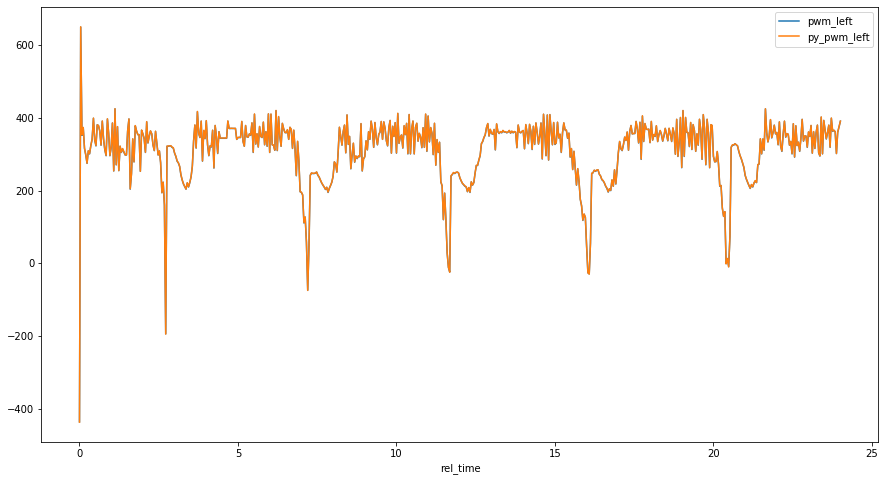

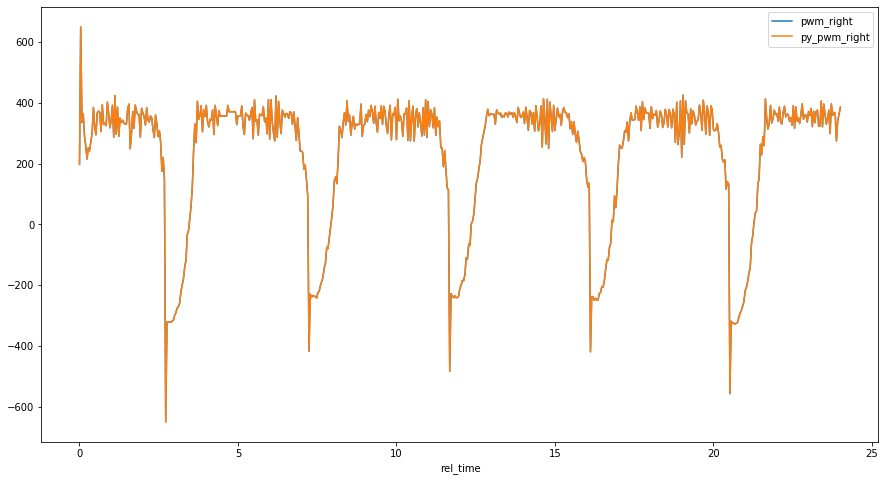

In [40]:
plt.rcParams['figure.figsize'] = (15.0, 8.0)
robot_tj.plot(y=['pwm_left', 'py_pwm_left'], x='rel_time')
robot_tj.plot(y=['pwm_right', 'py_pwm_right'], x='rel_time')

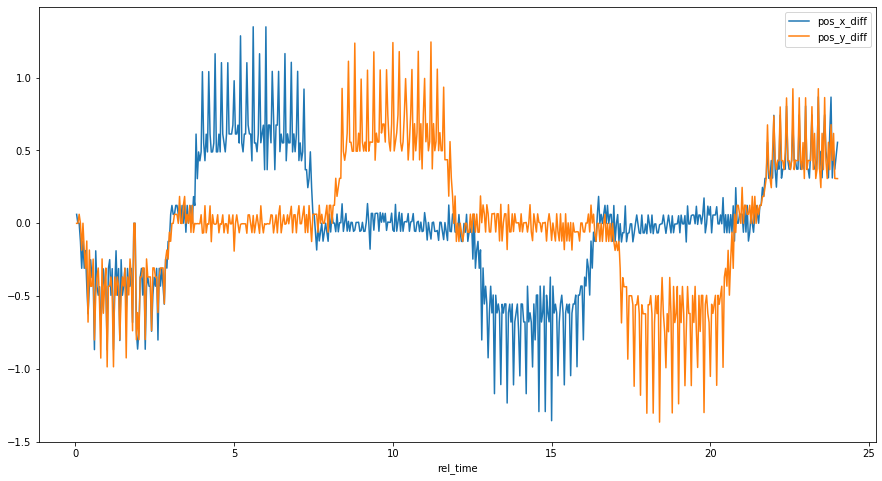

In [41]:
robot_tj.plot(x='rel_time', y=['pos_x_diff', 'pos_y_diff'])

In [42]:
t = 4
for i in robot_tj.index:
    if i < t:
        robot_tj.loc[i, 'x_vel_eff'] = 0
    else:
        robot_tj.loc[i, 'x_vel_eff'] = .975 * robot_tj.loc[i-1, 'x_vel_eff'] + 0.2 * (robot_tj.loc[i-t, 'py_x_vel'] - robot_tj.loc[i-t, 'x_vel_eff'])
        
t = 4
for i in robot_tj.index:
    if i < t:
        robot_tj.loc[i, 'r_vel_eff'] = 0
    else:
        robot_tj.loc[i, 'r_vel_eff'] = .96 * robot_tj.loc[i-1, 'r_vel_eff'] + 0.2 * (robot_tj.loc[i-t, 'py_r_vel'] - robot_tj.loc[i-t, 'r_vel_eff'])

Text(0, 0.5, 'rotational velocity [rad/s]')

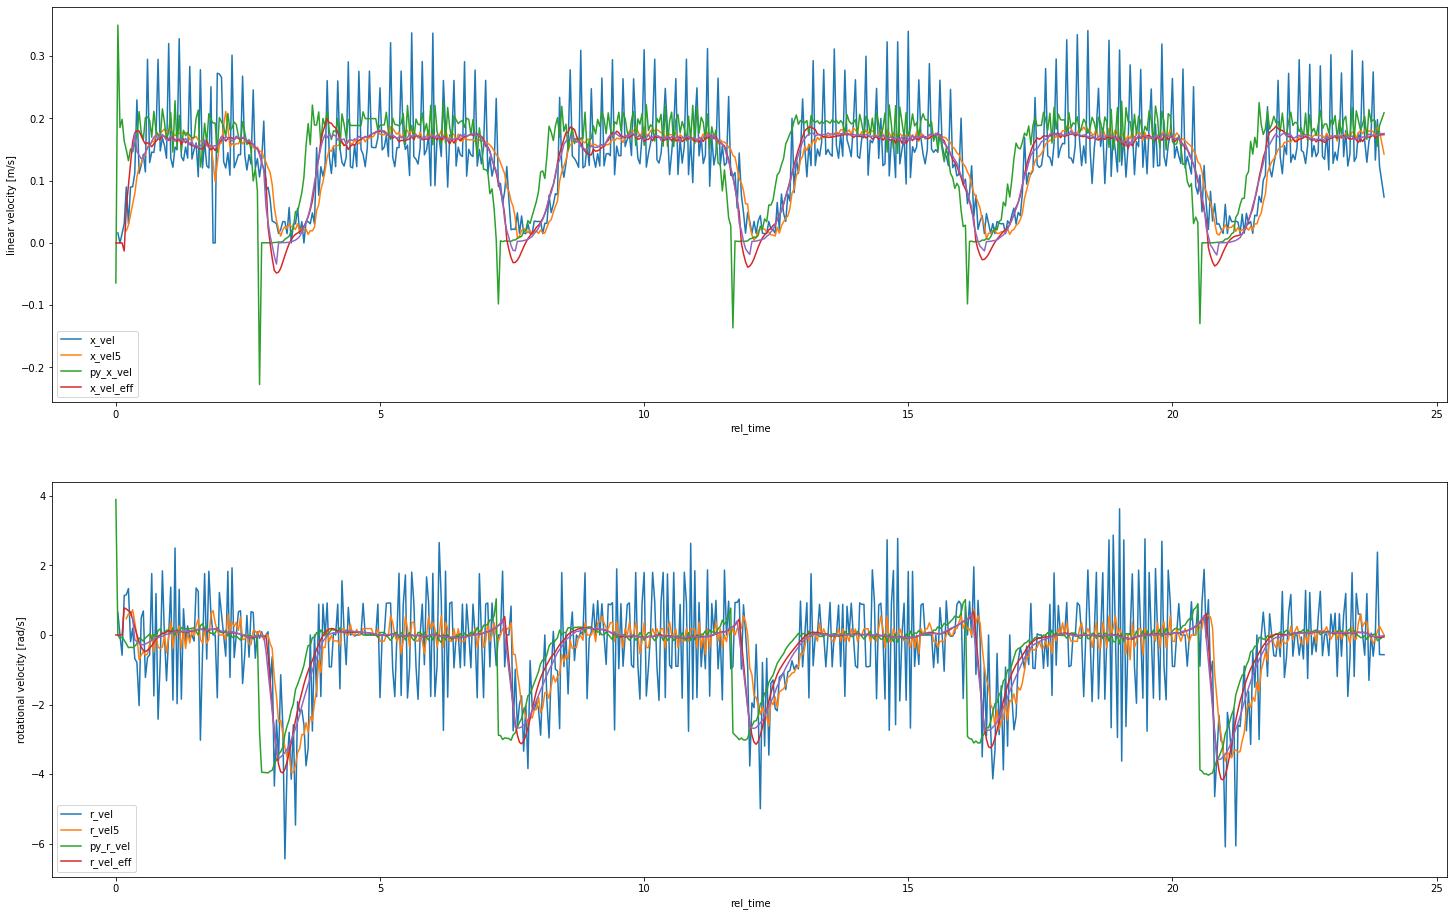

In [49]:
f, (ax1, ax2) = plt.subplots(2, figsize=(25,16))

plt.rcParams['figure.figsize'] = (15.0, 12.0)
l1 = robot_tj.plot(ax=ax1, y=['x_vel', 'x_vel5', 'py_x_vel', 'x_vel_eff'], x='rel_time')

(robot_tj.set_index('rel_time').py_x_vel.rolling(6).mean().shift(3) * .9).plot(ax=ax1)
l1.set_label('lin. vel.')
ax1.set_ylabel('linear velocity [m/s]')

l2 = robot_tj.plot(ax=ax2, y=['r_vel', 'r_vel5', 'py_r_vel', 'r_vel_eff'], x='rel_time')
(robot_tj.set_index('rel_time').py_r_vel.rolling(6).mean().shift(3) *.9).plot(ax=ax2)
l2.set_label('rot. vel.')
ax2.set_ylabel('rotational velocity [rad/s]')

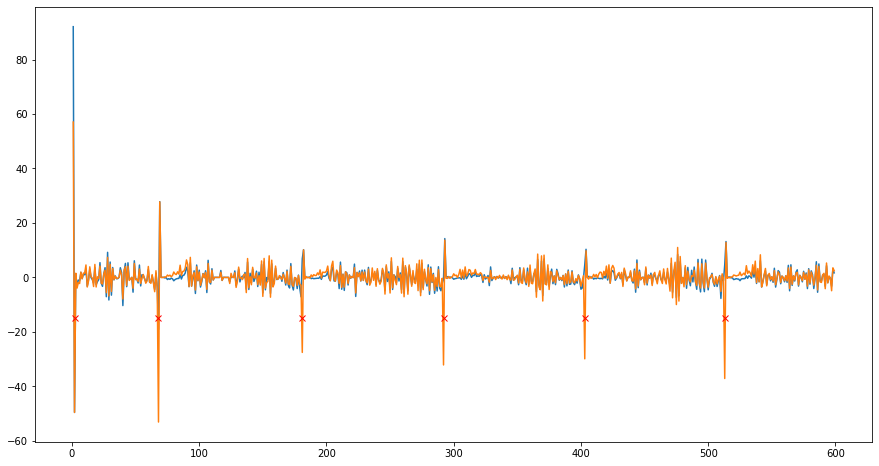

In [44]:
robot_tj['goal_switch'] = np.logical_or(robot_tj.speeds_left.diff() < -15, robot_tj.speeds_right.diff() < -10)
# robot_tj['goal_switch'] = robot_tj.speeds_right.diff() < -10
robot_tj.speeds_left.diff().plot()
robot_tj.speeds_right.diff().plot()
plt.plot(np.where(robot_tj.goal_switch), -15, 'xr')

In [46]:
from gym_guppy.tools.controller import _compute_errors

action_list = np.array([[.0, .0],
                        [-.3, .3],
                        [.3, .3],
                        [.3, -.3],
                        [-.3, -.3],
                        [-.3, .3],
                        [.0, .0],
                        [np.nan, np.nan]])

controller_params = {
    'ori_ctrl_params': {
        'p': 1.2,
        'i': 0.,
        'd': 0.,
        'speed': .2,
        'slope': .75  # .65
    },
    'fwd_ctrl_params': {
        'p': 1.,
        'i': 0.,
        'd': 1.,
        'speed': .2,
        'slope': .5,
        'ori_gate_slope': 3.
    }
}

tw_controller = TwoWheelsController(**controller_params)

action_i = 0
for i in robot_tj.index:
    if robot_tj.loc[i, 'goal_switch']:
        action_i += 1
        
    robot_tj.loc[i, 'goal_x'] = action_list[action_i, 0]
    robot_tj.loc[i, 'goal_y'] = action_list[action_i, 1]
    robot_tj.loc[i, 'ori_error'], robot_tj.loc[i, 'pos_error'] = _compute_errors(robot_tj.loc[i, ['pos_x_m', 'pos_y_m', 'ori_rad']].values * (1., 1., 1.), action_list[action_i])
    ori_ms, fwd_ms = tw_controller.speed_parts(robot_tj.loc[i, ['pos_x_m', 'pos_y_m', 'ori_rad']].values * (1., 1., 1.), action_list[action_i])
    ms = fwd_ms + ori_ms
    robot_tj.loc[i, 'py_fwd_speeds_left'] = fwd_ms.left * 100.
    robot_tj.loc[i, 'py_fwd_speeds_right'] = fwd_ms.right * 100.
    robot_tj.loc[i, 'py_ori_speeds_left'] = ori_ms.left * 100.
    robot_tj.loc[i, 'py_ori_speeds_right'] = ori_ms.right * 100.
    robot_tj.loc[i, 'py_speeds_left'] = ms.left * 100.
    robot_tj.loc[i, 'py_speeds_right'] = ms.right * 100.


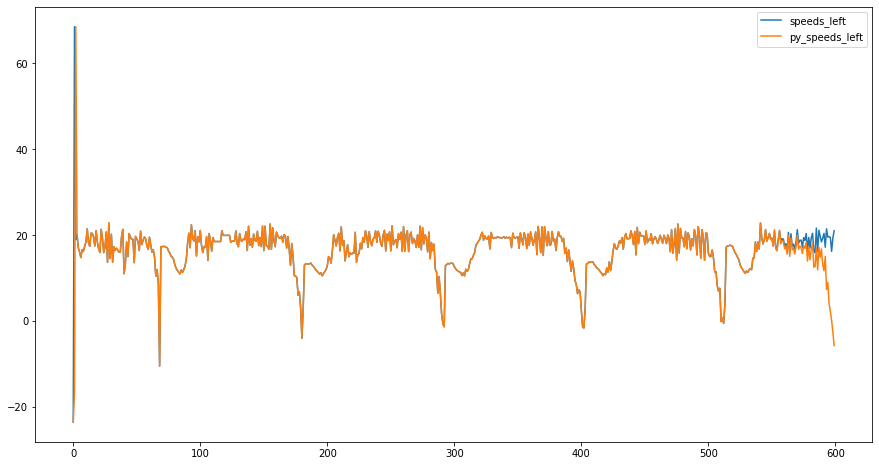

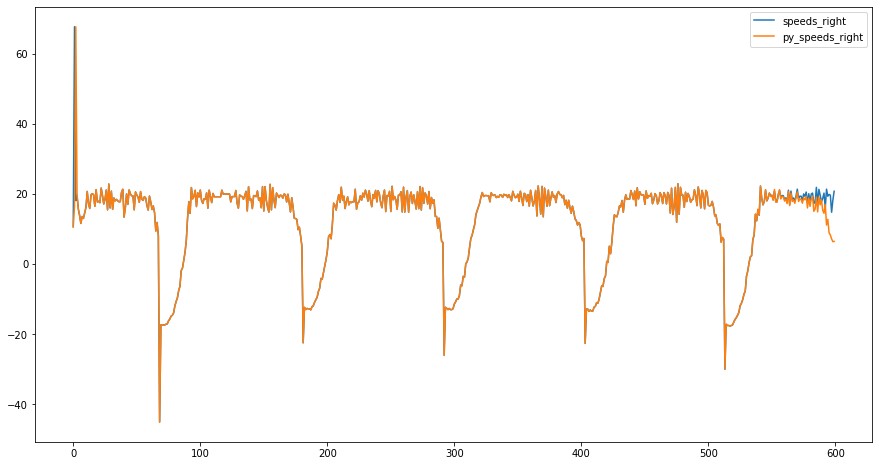

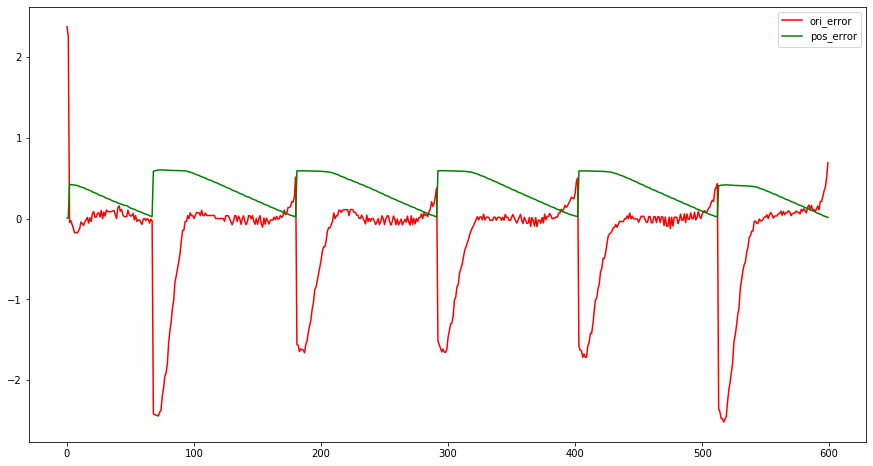

In [48]:
robot_tj.plot(y=['speeds_left', 'py_speeds_left'])
# ax2 = plt.gca().twinx()
# robot_tj.plot(ax=ax2, y=['ori_error', 'pos_error'], color=['r', 'g'])
robot_tj.plot(y=['speeds_right', 'py_speeds_right'])
# ax2 = plt.gca().twinx()
robot_tj.plot(y=['ori_error', 'pos_error'], color=['r', 'g'])

# robot_tj.plot(y=['speeds_left', 'py_speeds_left', 'py_ori_speeds_left', 'py_fwd_speeds_left'])
# robot_tj.plot(y=['speeds_right', 'py_speeds_right', 'py_ori_speeds_right', 'py_fwd_speeds_right'])
# robot_tj.plot(y=['py_speeds_left', 'py_speeds_right', 'py_fwd_speeds_left', 'py_fwd_speeds_right'])
# robot_tj.plot(y=['py_speeds_left', 'py_speeds_right', 'py_ori_speeds_left', 'py_ori_speeds_right'])

In [25]:
(robot_tj['speeds_left'] - robot_tj['py_speeds_left']).mean()

4.0131608512660195

In [26]:
(robot_tj['speeds_right'] - robot_tj['py_speeds_right']).mean()

-3.4261674385598826